In [1]:
from analysis import rois_to_pixels
from analysis import dff_images
from glob import glob
from pprint import pprint
from sklearn import decomposition
from skimage.transform import downscale_local_mean
from tifffile import imwrite
from visualization import plot_traces
from visualization import show_array_images
from visualization import show_images
from visualization import show_one_image
from wfield.io import mmap_dat

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
root_path = '/home/wrx/Data_WF/WF_WRX/'
# root_path = '/home/wrx/Data_DOM/Widefield'
mouse_id = 'U27'
date = '20250110'
treatment = 'natural-movie'

treatment_folder = os.path.join(root_path, mouse_id, f'{date}_{treatment}')
print(treatment_folder)

/home/wrx/Data_WF/WF_WRX/U27/20250110_natural-movie


In [ ]:
# the bin_path
stim_folders = [f for f in glob(os.path.join(treatment_folder, '*')) if \
    os.path.isdir(f)]
pprint(stim_folders)
wfield_folder = glob(os.path.join(stim_folders[0], 'process', '*wfield'))[0]
print(os.path.exists(wfield_folder))
bin_path = glob(os.path.join(wfield_folder, '*.bin'))[0]
print(bin_path)

In [3]:
# bin_path = '/home/wrx/Data_WF/WF_VC_liuzhaoxi/25.01.11_U26/baseline/process/20250111-212711-wfield/3000_2_512_512_uint16.bin'
# bin_path = '/home/wrx/Data_WF/WF_VC_liuzhaoxi/25.01.11_U26/natural-movie/process/20250111-214859-wfield/17999_2_512_512_uint16.bin'
bin_path = '/home/wrx/Data_WF/WF_VC_liuzhaoxi/25.01.10_U27/natural-movie/process/20250111-001641-wfield/18000_2_512_512_uint16.bin'

(18000, 2, 512, 512)


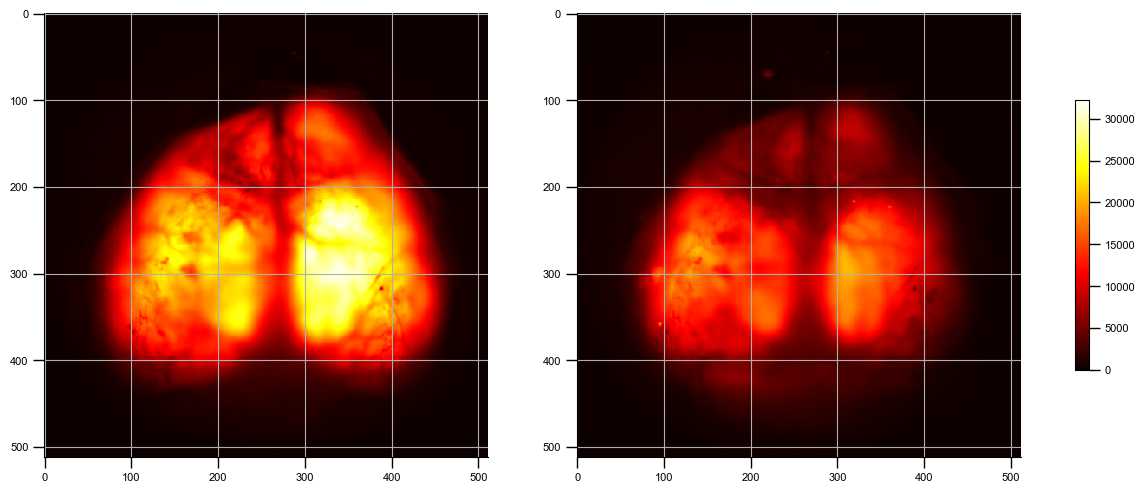

In [4]:
# read the bin file
data_raw = mmap_dat(bin_path)
print(data_raw.shape)

# to verify the channel order by showing the first frame
show_images([data_raw[0][0], data_raw[0][1]], idential_colorbar=True)

In [ ]:
start, end = 0, 300
data_preview = data_raw[start:end, 0, :, :]
print('Shape of data_preview:', data_preview.shape)
data_std = np.std(data_preview, axis=0)
show_one_image(data_std, cmap='hot', colorbar=True)

In [ ]:
reference_path = os.path.join(wfield_folder, 'reference.tif')
if os.path.exists(reference_path):
    print('Reference image already exists, skipping saving.')
else:
    imwrite(reference_path, data_mean.astype(np.uint16))

In [ ]:
# mask the reigion of not interest as 0 to reduce the noise
mask_path = os.path.join(wfield_folder, 'mask.zip')
pixels = rois_to_pixels(mask_path, data_std.shape)
print(pixels.shape)

data_masked = data_raw[:, 0, :, :].copy()
data_masked[:, pixels[1, :], pixels[0, :]] = 0
show_one_image(data_masked[0], cmap='hot', colorbar=True)

In [5]:
# for testing
data_masked = data_raw[:, 0, :, :].copy()

Downsampling

Shape of data_downsample: (18000, 128, 128)
Shape of _data: (18000, 16384)


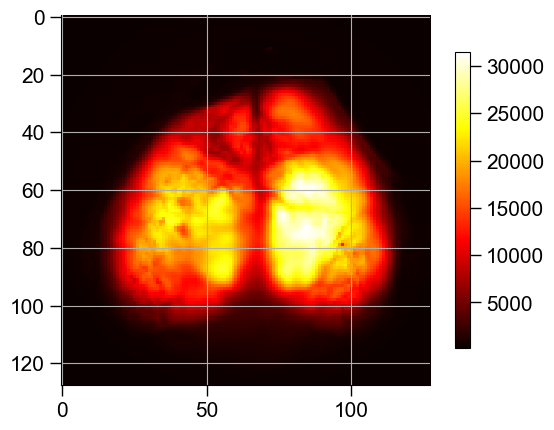

In [6]:
data_downsample = downscale_local_mean(data_masked, (1, 4, 4))
print('Shape of data_downsample:', data_downsample.shape)
_data = data_downsample.reshape(data_downsample.shape[0], -1)
print('Shape of _data:', _data.shape)
show_one_image(data_downsample[0], cmap='hot', colorbar=True)

$\Delta F / F$ of pixels

In [7]:
# calculate the dff of each pixel in the image
images_dff = dff_images(data_downsample)
print('Shape of images_dff:', images_dff.shape)
# replace the nans with 0
images_dff[np.isnan(images_dff)] = 0

Shape of images_dff: (18000, 128, 128)


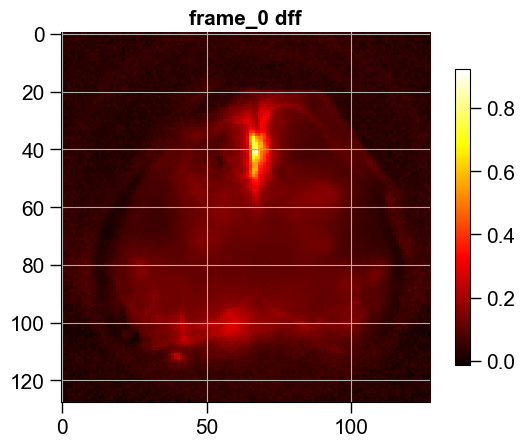

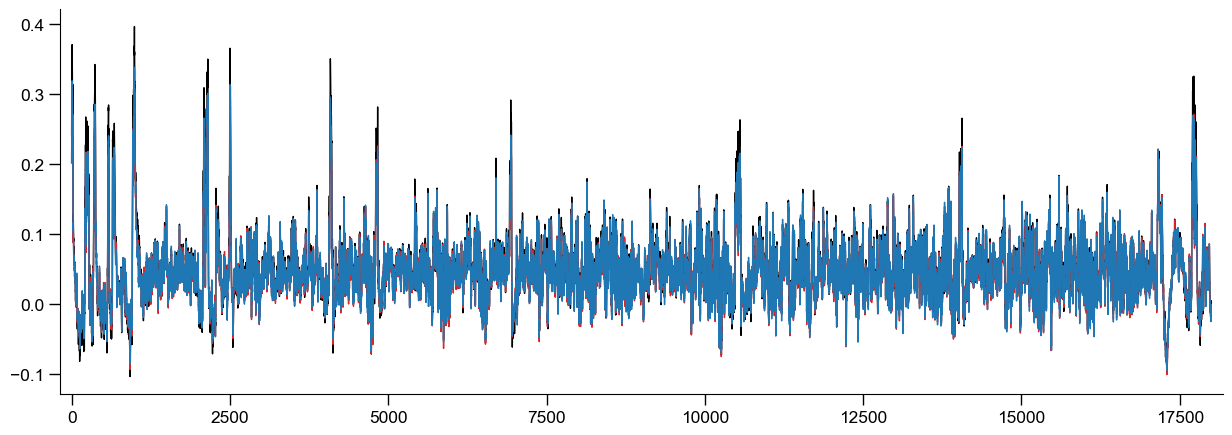

In [20]:
# show the dff image of selected frame
index = 0
title = f'frame_{index} dff'
show_one_image(images_dff[index], cmap='hot', colorbar=True, title=title)

# plot the dff trace of selected pixels
x, y = 70, 50
plot_traces(images_dff[:, y, x:x+3])

PCA in sklearn

In [9]:
X = images_dff.reshape(images_dff.shape[0], -1)
print('Shape of X:', X.shape)

Shape of X: (18000, 16384)


In [10]:
n_components = 40
whiten = True
svd_solver = 'randomized'
random_state = 42
pca_estimator = decomposition.PCA(n_components=n_components, whiten=whiten,
    svd_solver=svd_solver, random_state=random_state)
# X: {array-like, sparse matrix} of shape (n_samples, n_features)
pca_estimator.fit(X)

print('Explained variance ratio:',
    pca_estimator.explained_variance_ratio_.sum())

pac_components = pca_estimator.components_
print('Shape of pac_components:', pac_components.shape)

Explained variance ratio: 0.9393586079376218
Shape of pac_components: (40, 16384)


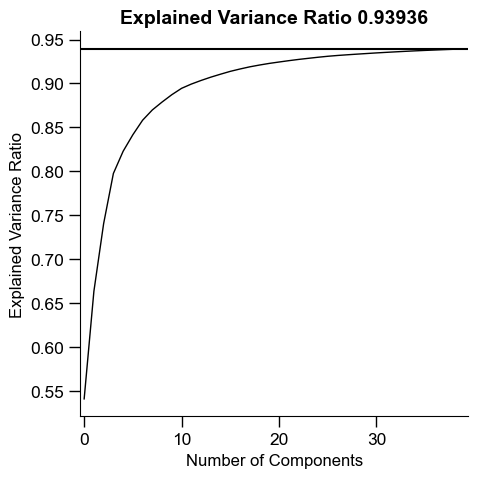

In [11]:
# plot the sum of explained variance ratio
explained_variance_sum = np.cumsum(pca_estimator.explained_variance_ratio_)
title = 'Explained Variance Ratio {:.5f}'.format(explained_variance_sum[-1])
plot_traces(explained_variance_sum[:, np.newaxis], figsize=(5, 5),
    title=title, xlabel='Number of Components',
    ylabel='Explained Variance Ratio', hlines=[explained_variance_sum[-1]])

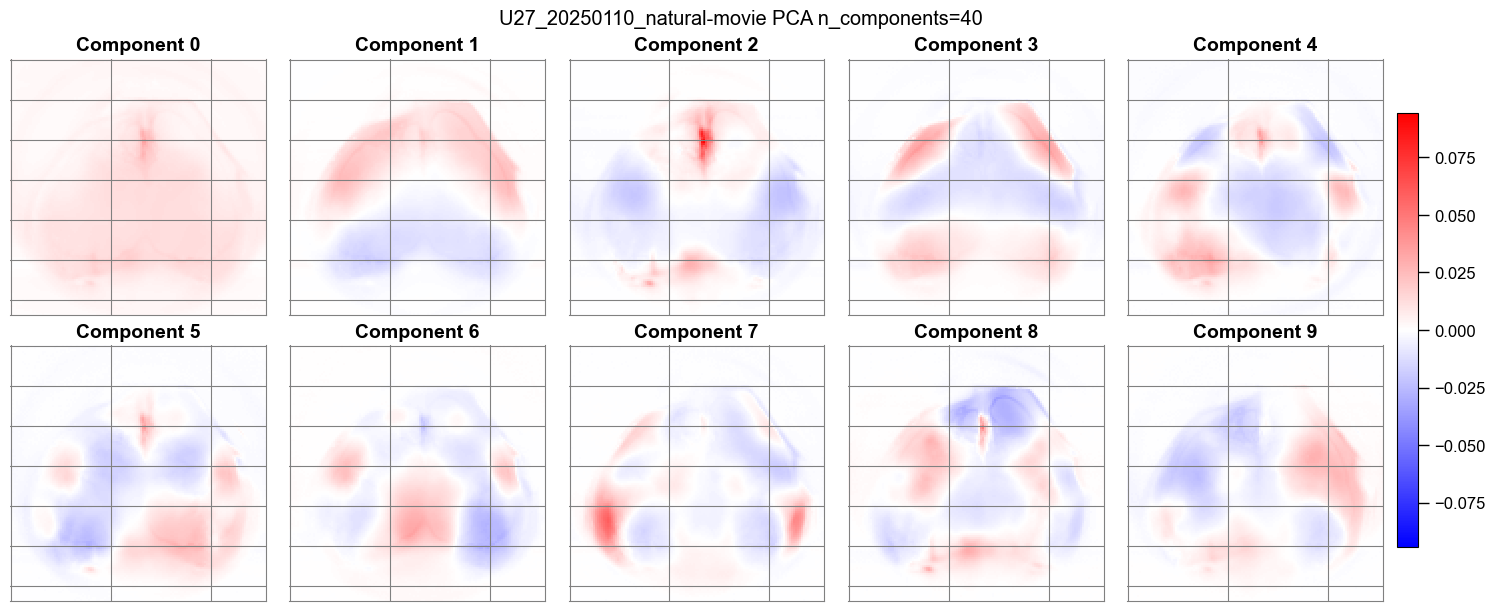

In [12]:
# show the components
n_show = 10
title = f'{mouse_id}_{date}_{treatment} PCA n_components={n_components}'
show_array_images(pac_components[: n_show].reshape(n_show,
    data_downsample.shape[1], data_downsample.shape[2]),
    cmap='bwr', title=title, grid=True)

In [ ]:
np.argmax(pac_components, axis=0)

(40, 16384)

In [33]:
pca_estimator.mixing_.shape

AttributeError: 'PCA' object has no attribute 'mixing_'

Timecourse

In [ ]:
timecourse = pca_estimator.transform(X)
print('Shape of timecourse:', timecourse.shape)

In [ ]:
title = f'{mouse_id}_{date}_{treatment} PCA Timecourse'
plot_dff(timecourse[:, :n_show], step=6, figsize=(15, 10), data_rate=10, 
    title=title, xlabel='Time (s)', ylabel='PCA Timecourse')

In [ ]:
data_inverse = pca_estimator.inverse_transform(pca_estimator.transform(X))
print('Shape of data_inverse:', data_inverse.shape)

In [ ]:
data_reconstruct = data_inverse.reshape(data_downsample.shape)
print('Shape of data_reconstruct:', data_reconstruct.shape)

PCA of custom

In [ ]:
def pca_x(X,centralize=True):
    """
    SVD approach for principal components analysis
    PV: principal axis 
    PC: principal components
    lambda: variance explained"""
    [n, p] = np.shape(X)                
    X_0 = np.zeros((n,p))
    if centralize:
        for i in range(p):
            X_0[:,i] =  X[:,i]-np.mean(X[:,i])
    else:
        X_0 = X
    [U,S,Vt] = np.linalg.svd(X_0)
    V = Vt.T
    lamda = np.square(S)/(n-1)
    lamda = lamda/np.sum(lamda)
    PV = V
    PC = X_0@PV #principal components
    return PV, lamda, PC, Vt, S

X = images_dff.reshape(images_dff.shape[0], -1)
print('Shape of X:', X.shape)
PV, lamda, PC, Vt, S = pca_x(X, centralize=True)
print('Shape of PV:', PV.shape)
print('Shape of lamda:', lamda.shape)
print('Shape of PC:', PC.shape)
print('Shape of Vt:', Vt.shape)
print('Shape of S:', S.shape)

In [ ]:
pca_components = PV[:, :n_show].T
print('Shape of pca_components:', pca_components.shape)
pca_components

In [ ]:
_index = pca_components.mean(axis=1) < 0
pca_components[_index, :] = -pca_components[_index, :]


In [ ]:
n_show = 10
show_array_images(pca_components.reshape(n_show,
    data_downsample.shape[1], data_downsample.shape[2]),
    cmap='bwr', title=title)

In [ ]:
n_components = 40
explained_variance_sum = np.cumsum(lamda[:n_components])

title = 'Explained variance sum: {:.6}'.format(
    explained_variance_sum[-1])
plot_traces(explained_variance_sum[:, np.newaxis], figsize=(5, 5),
    title=title, xlabel='Number of Components',
    ylabel='Explained Variance Ratio', hlines=[explained_variance_sum[-1]])

In [ ]:
def pca_analysis(X, variance_explained,plot_flag=True):
    if plot_flag:
        imshow_X(X,'original X')
    n_cells, n_samples = np.shape(X)
    pv, lamda, pc = pca_x(X,centralize=True)
    lamda_cumsum = np.cumsum(lamda)
    if plot_flag:
        fig, axes = plt.subplots(2, 1, sharex=True, figsize=(fig_width,fig_height/3))
        axes[0].plot(lamda[:100],marker='o')
        axes[1].plot(lamda_cumsum[:100],marker='o')
        axes[1].set_ylabel('variance explained')
        axes[1].set_xlabel('number of PCs')

    k = np.where(lamda_cumsum>variance_explained)[0][0]+1
    pc_k = pc[:,:k]
    pv_k = pv[:,:k]
  
    lamda_array = np.ones([n_samples,1])@np.reshape(lamda,(1,-1))
    pv_scaled = np.multiply(lamda_array,pv)
    
    if plot_flag:
        fig, axes = plt.subplots(2, 1, sharex=True, figsize=(fig_width,np.min([k/4,fig_height])))
        sns.heatmap(pv_scaled[:,:k].T,cmap='viridis',xticklabels=False, yticklabels=False, ax=axes[0])
        axes[0].set_title(str(k)+' principal vectors,'+ str(variance_explained*100) + '% of vraiance explained')
        sns.heatmap(pv_k.T,cmap='viridis',xticklabels=False, yticklabels=False, ax=axes[1])
        
        # plot principal components 
        imshow_X(pc[:,:k],'principal components',sampling_rate=1)
        # visualize the first 2 PCs
        plt.figure(figsize=(fig_width,fig_height/3))
        plt.scatter(pc[:,0],pc[:,1],s=20,facecolors='none',edgecolors='k',marker='^',alpha=0.3)
        plt.xlabel('PC 1')
        plt.ylabel('PC 2')
    # reconstruct X with PCs that explain variance_explained of variance
    k =np.where(lamda_cumsum>variance_explained)[0][0]+1
    X_0_new = pc[:,:k]@pv[:,:k].T
    X_new = np.zeros_like(X)
    for i in range(n_samples):
        X_new[:,i] =  X_0_new[:,i]+np.mean(X[:,i])
    if plot_flag:
        imshow_X(X_new,'reconstructed X with '+str(k)+' PCs')
    return k, pc_k, pv_scaled, X_new, lamda_cumsum

FastICA

In [21]:
n_components = 10
max_iter = 1000
random_state = 42
ica_estimator = decomposition.FastICA(n_components=n_components,
    max_iter=max_iter, random_state=random_state)

# X: array-like of shape (n_samples, n_features)
X = images_dff.reshape(images_dff.shape[0], -1)
# X = data_inverse
print('Shape of X:', X.shape)
ica_estimator.fit(X)

Shape of X: (18000, 16384)


FastICA(max_iter=1000, n_components=10, random_state=42)

In [59]:
ica_estimator.mixing_.T.shape

(10, 16384)

Shape of img: (128, 128)


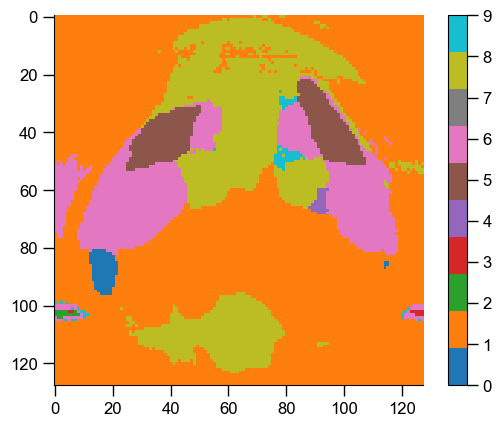

In [44]:
img = np.argmax(ica_estimator.mixing_, axis=1).reshape(128, 128)
print('Shape of img:', img.shape)
plt.imshow(img, cmap='tab10')
plt.colorbar()
plt.show()

Shape of reshaped ICA components: (10, 128, 128)


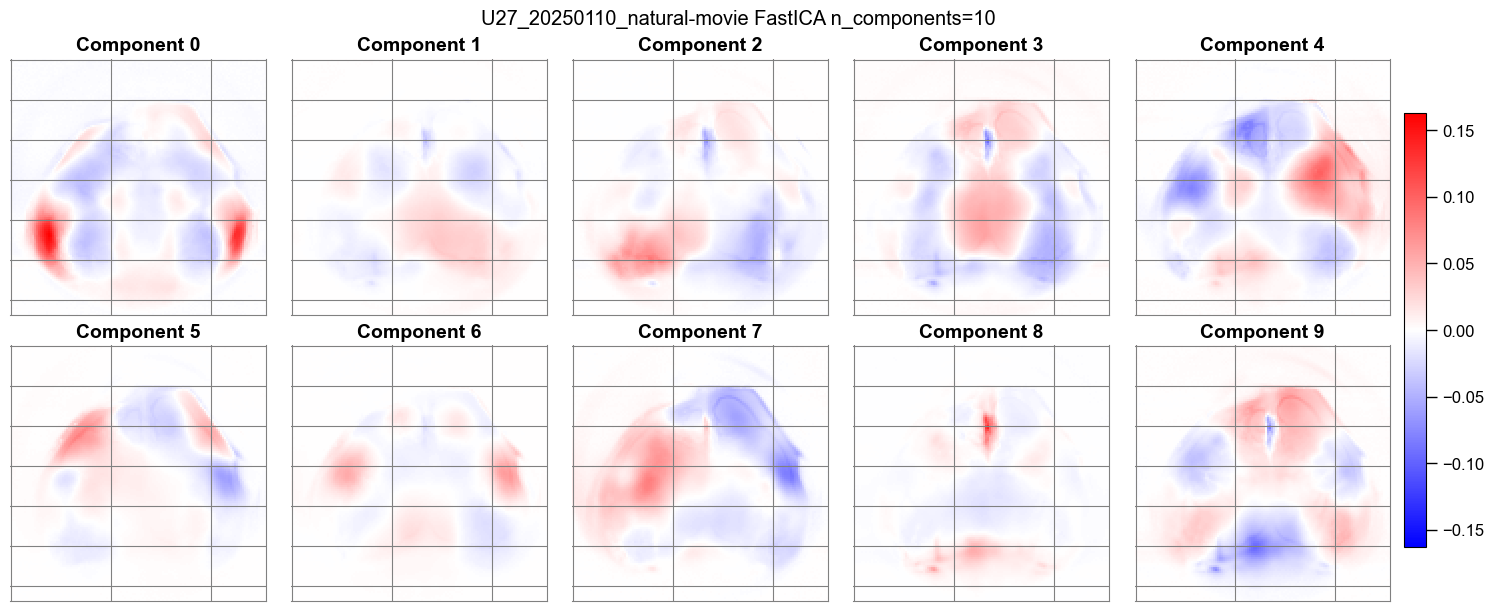

In [22]:
ica_components = ica_estimator.components_.reshape(n_components, 
    *data_downsample.shape[1:])
print('Shape of reshaped ICA components:', ica_components.shape)

# to deal with signs of the components
_index = ica_components.mean(axis=(1, 2)) < 0
ica_components[_index] = -ica_components[_index]

title = f'{mouse_id}_{date}_{treatment} FastICA n_components={n_components}'
show_array_images(ica_components, n_cols=5, cmap='bwr', title=title)

In [ ]:
components_masked = ica_components.copy()
components_masked[np.abs(ica_components) < 0.3 * ica_components.max()] = 0
show_array_images(components_masked, n_cols=5, cmap='bwr')

In [ ]:
components_sum = np.sum(components_masked, axis=0)
show_one_image(components_sum, cmap='bwr')

In [48]:
ica_components.shape

(10, 128, 128)

In [57]:
length = np.linalg.norm(ica_estimator.components_, axis=1)
print(length)

[2.69008062 1.17648873 1.91172931 2.16713031 2.80132086 1.66690728
 1.23112923 2.5249957  1.15389444 2.36287701]


In [52]:
normal_components = ica_estimator.components_ / length[:, np.newaxis]
print('Shape of normal_components:', normal_components.shape)

Shape of normal_components: (10, 16384)


In [55]:
inverse_components = np.linalg.pinv(normal_components)
print('Shape of inverse_components:', inverse_components.shape)

Shape of inverse_components: (16384, 10)


Shape of img: (128, 128)


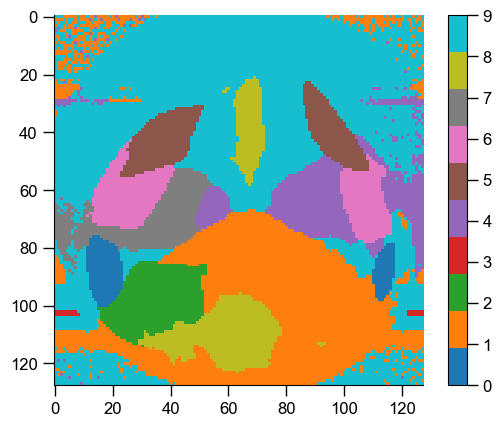

In [56]:
img = np.argmax(inverse_components, axis=1).reshape(128, 128)
print('Shape of img:', img.shape)
plt.imshow(img, cmap='tab10')
plt.colorbar()
plt.show()

jadeR for ICA

In [23]:
import sys
sys.path.append('./ICA')
from jadeR import jadeR

In [24]:
X = images_dff.reshape(images_dff.shape[0], -1).T
# X = data_inverse.T
print('Shape of X:', X.shape)

n_IC = 10
jade_ica = jadeR(X, m=n_IC, verbose=True)

Shape of X: (16384, 18000)
jade -> Looking for 10 sources
jade -> Removing the mean value
jade -> Whitening the data
jade -> Estimating cumulant matrices
jade -> Contrast optimization by joint diagonalization
jade -> Sweep #  0
completed in 45 rotations
jade -> Sweep #  1
completed in 45 rotations
jade -> Sweep #  2
completed in 45 rotations
jade -> Sweep #  3
completed in 45 rotations
jade -> Sweep #  4
completed in 45 rotations
jade -> Sweep #  5
completed in 45 rotations
jade -> Sweep #  6
completed in 45 rotations
jade -> Sweep #  7
completed in 45 rotations
jade -> Sweep #  8
completed in 45 rotations
jade -> Sweep #  9
completed in 45 rotations
jade -> Sweep # 10
completed in 44 rotations
jade -> Sweep # 11
completed in 45 rotations
jade -> Sweep # 12
completed in 41 rotations
jade -> Sweep # 13
completed in 40 rotations
jade -> Sweep # 14
completed in 37 rotations
jade -> Sweep # 15
completed in 31 rotations
jade -> Sweep # 16
completed in 24 rotations
jade -> Sweep # 17
complet

In [25]:
# to deal with signs of the components
signs = np.sign(jade_ica.mean(axis=1))
for i in range(jade_ica.shape[0]):
    jade_ica[i, :] *= signs[i][0, 0]
print(jade_ica.shape)

(10, 16384)


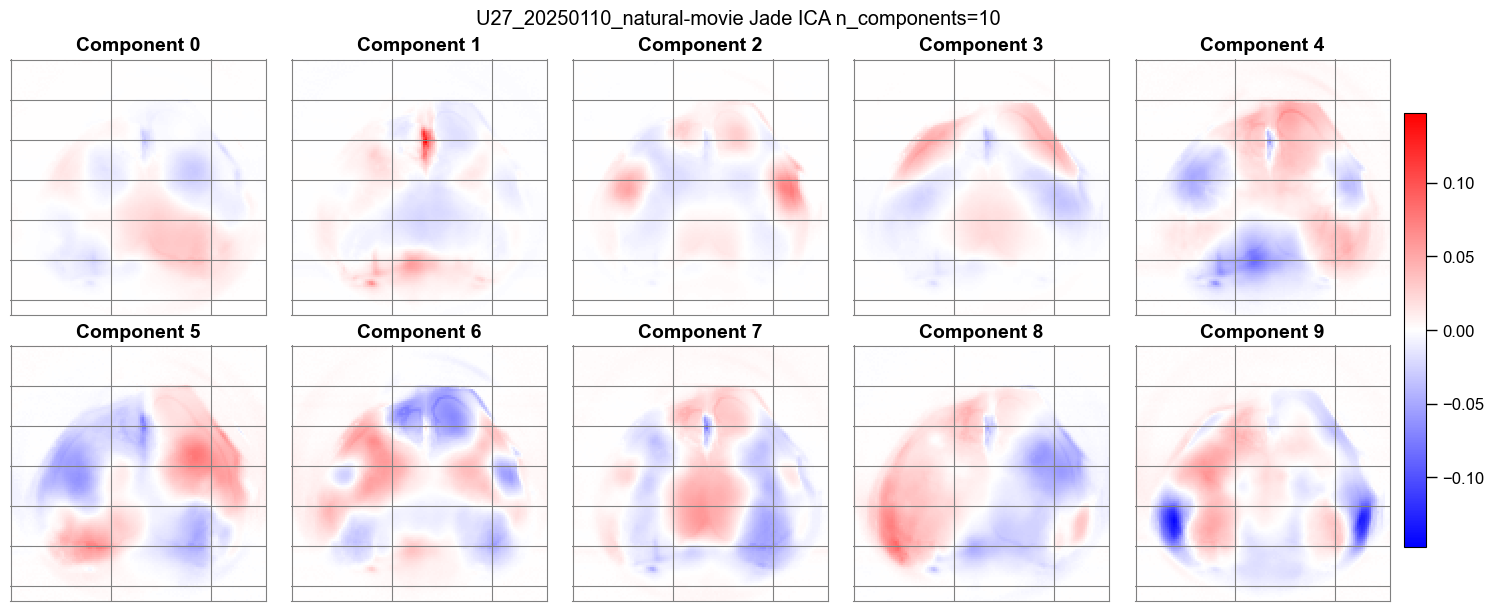

In [26]:
title = f'{mouse_id}_{date}_{treatment} Jade ICA n_components={n_IC}'
show_array_images(np.array(jade_ica).reshape(n_IC,
    data_downsample.shape[1], data_downsample.shape[2]),
    cmap='bwr', title=title, grid=True)